In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"


# from utils import CustomDataset, GANLoss, Vgg19
# from generator import AttU_Net
# from discriminator import Discriminator

from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Read data

In [2]:
img_path = "../OCR_data/doc_unet/original/1_1.jpg"
im = Image.open(img_path)
#im = im.resize((num_pixels_y, num_pixels_x))
im = np.array(im)

print(f"0: {im.shape[0] // 2}, 1: {im.shape[1] // 2}")


0: 2016, 1: 1512


In [3]:
orig_base_path = "../OCR_data/doc_unet/original/"
crop_base_path = "../OCR_data/doc_unet/crop/"
scan_base_path = "../OCR_data/doc_unet/scan/"

num_pixels_x, num_pixels_y, num_channels = 2016//4, 1512//4, 3

orig_images = np.zeros((len(os.listdir(orig_base_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)
crop_images = np.zeros((len(os.listdir(orig_base_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)
scan_images = np.zeros((len(os.listdir(orig_base_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)

In [4]:
from tqdm import tqdm
for count, im_path in enumerate(tqdm(sorted(os.listdir(orig_base_path)))):

    im = Image.open(f"{orig_base_path}/{im_path}")
    im = im.resize((num_pixels_y, num_pixels_x))
    im = np.array(im)

    orig_images[count] = im
    #print(i)

100%|███████████████████████████████████████████████████████████████████████████████| 130/130 [00:24<00:00,  5.33it/s]


In [5]:
for count, im_path in enumerate(tqdm(sorted(os.listdir(crop_base_path)))):

    im = Image.open(f"{crop_base_path}/{im_path}")
    im = im.resize((num_pixels_y, num_pixels_x))
    im = np.array(im)

    crop_images[count] = im
    #print(i)

100%|███████████████████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.90it/s]


In [6]:
#Rename scan folder to make everything sorted
# for im_path in sorted(os.listdir(scan_base_path)):
#     os.rename(f"{scan_base_path}{im_path}", f"{scan_base_path}{im_path[:-4]}_1.png")

for count, im_path in enumerate(tqdm(sorted(os.listdir(scan_base_path)))):

    cur_count = count*2
    im = Image.open(f"{scan_base_path}/{im_path}")
    im = im.convert('RGB')
    im = im.resize((num_pixels_y, num_pixels_x))
    im = np.array(im)

    scan_images[cur_count] = im
    scan_images[cur_count+1] = im
    

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:13<00:00,  4.84it/s]


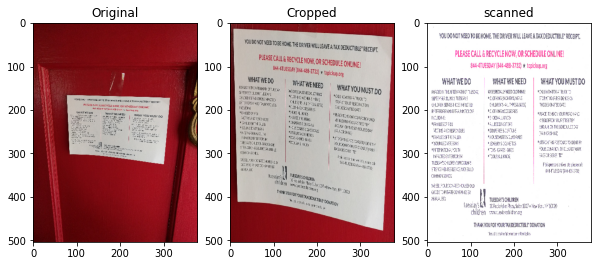

In [7]:
f, axarr = plt.subplots(1,3, figsize=(10,7))

i = -2

cur_orig = orig_images[i]
cur_crop = crop_images[i]
cur_scan = scan_images[i]


axarr[0].imshow(cur_orig)
axarr[0].title.set_text('Original')

axarr[1].imshow(cur_crop)
axarr[1].title.set_text('Cropped')

axarr[2].imshow(cur_scan)
axarr[2].title.set_text('scanned')

In [8]:
# with open(f"../OCR_data/doc_unet/orig.npy", 'wb') as f:
#     np.save(f, orig_images)
    
# with open(f"../OCR_data/doc_unet/crop.npy", 'wb') as f:
#     np.save(f, crop_images)
    
# with open(f"../OCR_data/doc_unet/scan.npy", 'wb') as f:
#     np.save(f, scan_images)
    
    
# with open(f"../OCR_data/doc_unet/orig.npy", 'rb') as f:
#     orig_images = np.load(f)
    
# with open(f"../OCR_data/doc_unet/crop.npy", 'rb') as f:
#     crop_images = np.load(f)
    
# with open(f"../OCR_data/doc_unet/scan.npy", 'rb') as f:
#     scan_images = np.load(f)    

# Phase 1: get cropped image

In [9]:
x_train, x_test, y_train, y_test = train_test_split(orig_images, crop_images, test_size=0.2, random_state=42)


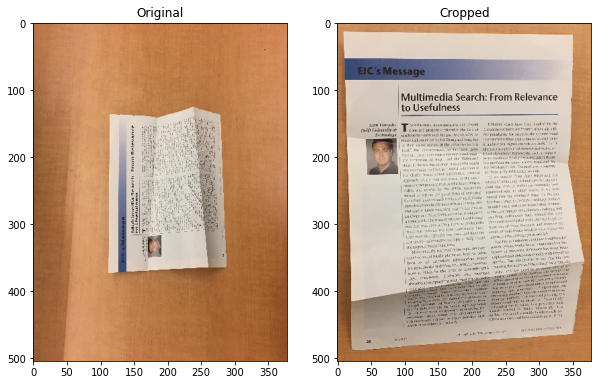

In [10]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = -6

cur_orig = x_train[i]
cur_crop = y_train[i]
#cur_scan = scan_images[i]


axarr[0].imshow(cur_orig)
axarr[0].title.set_text('Original')

axarr[1].imshow(cur_crop)
axarr[1].title.set_text('Cropped')

# axarr[2].imshow(cur_scan)
# axarr[2].title.set_text('scanned')

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform_input=None, transform_output=None ):
        self.transform_input = transform_input
        self.transform_output = transform_output

        self.data = np.transpose(x_data, (0, 3, 1, 2))
        self.targets = np.transpose(y_data, (0, 3, 1, 2))

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):

        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform_input(x)

        y = Image.fromarray(self.targets[index].astype(np.uint8).transpose(1, 2, 0))      
        y = self.transform_output(y)

        return x, y


In [12]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=[-10,10], translate=[0.00,0.08], scale=[0.95,1.00], shear=1, fill=(0,0,0)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ], std = [ 0.5, 0.5, 0.5 ]),
    #transforms.RandomErasing(scale=[0.05, 0.08], ratio=[0.02,0.05], p=0.5),
])

transform_output = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ], std = [ 0.5, 0.5, 0.5 ]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ], std = [ 0.5, 0.5, 0.5 ]),

])

In [13]:
train_set = CustomDataset(x_train, y_train,
                          transform_input=transform_train, 
                          transform_output=transform_output, 
                         )
trainloader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=4)

test_set = CustomDataset(x_test, y_test, 
                          transform_input=transform_train, 
                          transform_output=transform_output, 
                        )
testloader = torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=True, num_workers=4)

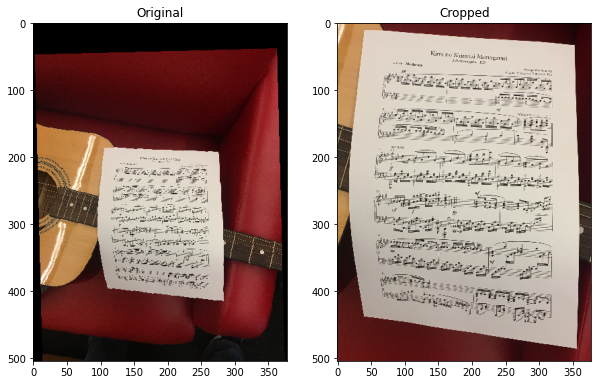

In [14]:
#Sanity test
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
    
for x,y in trainloader:
    break

    
unorm = UnNormalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
image_x = unorm(x)
image_y = unorm(y)

image_x = torch.permute(image_x, (0, 2,3, 1)).numpy()
image_y = torch.permute(image_y, (0, 2,3, 1)).numpy()


f, axarr = plt.subplots(1,2, figsize=(10,7))
i = 0
cur_orig = image_x[i]
cur_crop = image_y[i]
#cur_scan = scan_images[i]


axarr[0].imshow(cur_orig)
axarr[0].title.set_text('Original')

axarr[1].imshow(cur_crop)
axarr[1].title.set_text('Cropped')

In [15]:
from models.u2net import U2NETP

In [16]:
generator = U2NETP()
#generator = nn.DataParallel(generator)
generator.to(device)

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [17]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = x + (0.1**0.5)*(torch.randn(x.shape[0], x.shape[1], x.shape[2], x.shape[3])).cuda()
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [18]:

discriminator = Discriminator()

#discriminator = nn.DataParallel(discriminator)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [19]:
from torchvision.models import vgg19
from collections import namedtuple

class Vgg19(torch.nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        features = list(vgg19(pretrained = True).features)[:36]
        self.features = nn.ModuleList(features).eval()
        
    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {2,7,12,21,30}:
                results.append(x)
        return results    

In [20]:
perceptual_model = Vgg19()

#perceptual_model = nn.DataParallel(perceptual_model)
perceptual_model.to(device)

Vgg19(
  (features): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [21]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)    

In [22]:
lr=0.0005


criterion_g = torch.nn.MSELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr,
                             betas=(0.5, 0.999)
                            )


criterion_d = GANLoss().to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr,
                             betas=(0.5, 0.999)
                            )

criterion_p = torch.nn.MSELoss()
    

In [23]:
train_total = len(train_set)
train_batches = len(trainloader)

test_total = len(test_set)
test_baches = len(testloader)

In [24]:
num_epochs = 50

patience = 0    # Bad epoch counter
best_loss = 1024


/home/2017310887/miniconda3/envs/fl2/lib/python3.7/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/2017310887/miniconda3/envs/fl2/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/2017310887/miniconda3/envs/fl2/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[ 1 / 50] train_loss: 21.33029   test_loss: 0.25902 -- Best loss: 1024.00000 --- 22.11 seconds


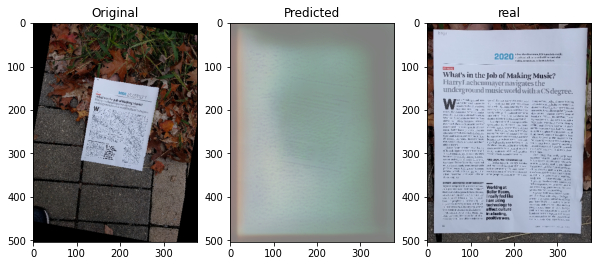

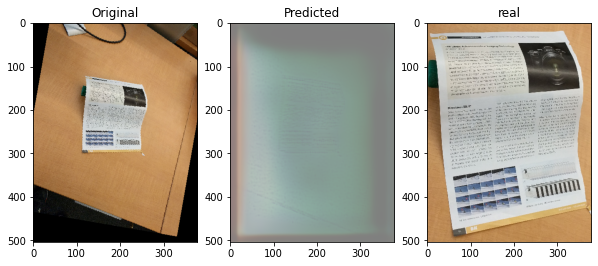

KeyboardInterrupt: 

In [25]:
count = 0
for epoch in range(num_epochs):
    # Train
    
    
    generator.train()
    discriminator.train()

    train_loss = 0
    train_correct = 0

    start_time = time.time()
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)

        #forward
        fake, _, _, _, _, _, _ = generator(x)
        
        
        #########################
        # (1) Calculate Perceptual Loss
        #########################

        fake_feature = perceptual_model(fake)
        real_feature = perceptual_model(y)

        loss_p = 0
        for i in range(5):
            loss_p += criterion_p(fake_feature[i], real_feature[i])        
        
        
        ##########################
        # (2) Update Discriminator
        ##########################
        
        #Train with fake
        optimizer_d.zero_grad()
        pred_fake = discriminator(fake)
        loss_d_fake = criterion_d(pred_fake, False)
        
        #Train with real
        pred_real = discriminator(y)
        loss_d_real = criterion_d(pred_real, True)
        
        #Average and update
        loss_d_total = (loss_d_fake + loss_d_real) * 0.5
        loss_d_total.backward(retain_graph=True)
        optimizer_d.step()
        
        
        ###########################
        # (3) Update Generator
        ###########################
        optimizer_g.zero_grad()
        
        #Get Discriminator Loss
        pred_fake = discriminator(fake)
        loss_gan = criterion_d(pred_fake, True)
        
        
        #Get Generator Loss
        loss_g = criterion_g(fake, y)
        
        loss_total = loss_gan + loss_g + loss_p
        loss_total.backward(retain_graph=True)
        optimizer_g.step()

        train_loss += loss_total.item()

    train_loss = train_loss / train_batches

    #scheduler.step(1.)

    end_time = time.time()
    
    print('[%2d / %d] train_loss: %.5f  ' % (epoch+1, num_epochs , train_loss), end = ' ')
        
    generator.eval()
    
    
    ### test acc ###
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            x, y = data[0].to(device), data[1].to(device)
            outputs, _,_,_,_,_,_ = generator(x)
            
            loss = criterion_g(outputs, y)
            test_loss += loss.item()
            
            
        test_loss = test_loss / test_baches
        
#         if(test_loss < best_loss):
#             torch.save(generator.state_dict(), path_checkpoint)
#             torch.save(discriminator.state_dict(), path_checkpoint2)
#             best_loss = test_loss
        print('test_loss: %.5f -- Best loss: %.5f --- %.2f seconds' %(test_loss, best_loss, (end_time-start_time)))    
        
        
    unorm = UnNormalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    x = unorm(x)
    y_hat = unorm(outputs)
    y = unorm(y)

    x = torch.permute(x.detach().cpu(), (0, 2,3, 1)).numpy()
    y_hat = torch.permute(y_hat.detach().cpu(), (0, 2,3, 1)).numpy()
    y = torch.permute(y.detach().cpu(), (0, 2,3, 1)).numpy()

    for i in range(len(x)):
        f, axarr = plt.subplots(1,3, figsize=(10,7))


        cur_orig = x[i]
        cur_pred = y_hat[i]
        cur_crop = y[i]
        #cur_scan = scan_images[i]


        axarr[0].imshow(cur_orig)
        axarr[0].title.set_text('Original')

        axarr[1].imshow(cur_pred)
        axarr[1].title.set_text('Predicted')

        axarr[2].imshow(cur_crop)
        axarr[2].title.set_text('real')
        plt.show()